In [167]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from backtesting import Backtest, Strategy

In [168]:
df = yf.download("MSFT")
df = df.loc["2017-12-12":,:]
df['change_tomorrow'] = df["Adj Close"].pct_change(-1) * 100 * -1
df = df.dropna().copy()
df

[*********************100%***********************]  1 of 1 completed
/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_28264/79893226.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change_tomorrow'] = df["Adj Close"].pct_change(-1) * 100 * -1


,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2017-12-12,85.309998,86.050003,85.080002,85.580002,79.449425,23924100,-0.269488
2017-12-13,85.739998,86.000000,85.169998,85.349998,79.235893,22062700,-0.779288
2017-12-14,85.430000,85.870003,84.529999,84.690002,78.623192,19306000,2.487034
2017-12-15,85.260002,87.089996,84.879997,86.849998,80.628448,53936700,-0.544100
2017-12-18,87.120003,87.500000,86.230003,86.379997,80.192123,22283800,-0.640836
...,...,...,...,...,...,...,...
2024-09-20,437.220001,439.239990,434.220001,435.269989,435.269989,55167100,-0.405984
2024-09-23,434.279999,436.459991,430.390015,433.510010,433.510010,15128900,-1.011253
2024-09-24,433.000000,433.350006,426.100006,429.170013,429.170013,17015800,0.680376


In [169]:
target = df.change_tomorrow
explanatory = df[['Open','High','Low','Close','Volume']]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(explanatory, target, test_size=0.2, random_state=42)

[Text(0.7566515771028037, 0.9705882352941176, 'Volume <= 56105050.0\nsquared_error = 3.407\nsamples = 1366\nvalue = 0.055'),
 Text(0.5664443795430945, 0.9117647058823529, 'Close <= 85.18\nsquared_error = 2.673\nsamples = 1313\nvalue = 0.087'),
 Text(0.6615479783229491, 0.9411764705882353, 'True  '),
 Text(0.5094236760124611, 0.8529411764705882, 'High <= 87.875\nsquared_error = 0.307\nsamples = 2\nvalue = 3.041'),
 Text(0.5077622014537903, 0.7941176470588235, 'squared_error = 0.0\nsamples = 1\nvalue = 2.487'),
 Text(0.5110851505711319, 0.7941176470588235, 'squared_error = -0.0\nsamples = 1\nvalue = 3.595'),
 Text(0.6234650830737279, 0.8529411764705882, 'Volume <= 37795750.0\nsquared_error = 2.663\nsamples = 1311\nvalue = 0.082'),
 Text(0.5144080996884736, 0.7941176470588235, 'Volume <= 37724900.0\nsquared_error = 2.265\nsamples = 1151\nvalue = 0.046'),
 Text(0.44797507788161994, 0.7352941176470589, 'Low <= 245.825\nsquared_error = 2.252\nsamples = 1149\nvalue = 0.052'),
 Text(0.32009345

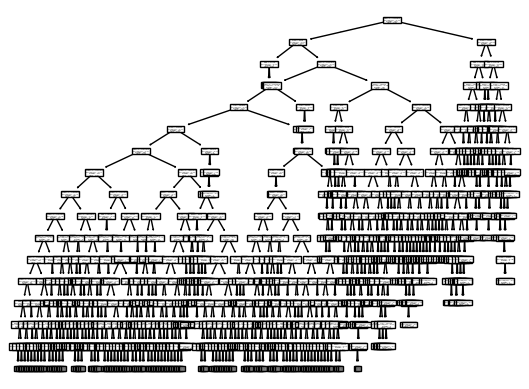

In [171]:
model_dt = DecisionTreeRegressor()
model_dt.fit(X=X_train,y=y_train)
plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_, max_depth=15)

In [172]:
r_squared = model_dt.score(X=X_test,y=y_test)
print(f"R^2: {r_squared}")

R^2: -1.4112779342408062


In [173]:
scores = cross_val_score(model_dt, explanatory, target, cv=5)
print(f"Cross-validated R^2 score: {scores.mean():.4f}")

Cross-validated R^2 score: -1.1144


Backtesting

In [174]:
class Regression(Strategy):  
    def init(self):
        self.model = model_dt 
        self.already_bought = False

    def next(self):
        latest_data = {
            'Open': self.data.Open[-1],
            'High': self.data.High[-1],
            'Low': self.data.Low[-1],
            'Close': self.data.Close[-1],
            'Volume': self.data.Volume[-1]
        }
        explanatory_today = pd.DataFrame([latest_data])
        
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > 5 and not self.already_bought:  
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < -6 and self.already_bought:  
            self.sell()
            self.already_bought = False

In [175]:
bt = Backtest(df, Regression, cash=10000, commission=0.002, exclusive_orders=True) 
stats = bt.run()
stats

Start                     2017-12-12 00:00:00
End                       2024-09-26 00:00:00
Duration                   2480 days 00:00:00
Exposure Time [%]                   87.177986
Equity Final [$]                 24457.693183
Equity Peak [$]                  26276.013252
Return [%]                         144.576932
Buy & Hold Return [%]              403.984562
Return (Ann.) [%]                   14.105664
Volatility (Ann.) [%]               30.510716
Sharpe Ratio                         0.462318
Sortino Ratio                        0.785773
Calmar Ratio                         0.349695
Max. Drawdown [%]                  -40.337098
Avg. Drawdown [%]                   -4.088865
Max. Drawdown Duration      727 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                   11
Win Rate [%]                        45.454545
Best Trade [%]                      80.496961
Worst Trade [%]                    -23.661761
Avg. Trade [%]                    

Links to the dashboard with the trading performance

In [176]:
bt.plot()

Row(id='5487', ...)